In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd               #data loading
path="/content/drive/MyDrive/traffic.csv"
df=pd.read_csv(path)
df.describe  #used to generate summary statistics about data frame

<bound method NDFrame.describe of                   DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
...                    ...       ...       ...          ...
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]>

In [ ]:
import numpy as np                      # to perform wide variety of mathematical operations
import pandas as pd                     # data processing,working with dataset
import os                               #The os module provides a wide range of functions and methods for tasks related to file and directory operations, as well as interacting with the underlying operating system.
for dirname, _, filenames in os.walk('/kaggle/input'):    #Directory enumeration
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install torchinfo            #provide info predicted by model in pytorch

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns               #data visualization
from sklearn.metrics import r2_score, mean_absolute_error   #measure classification performance
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import torch                    #open src ml lib used for creating deep neural network
import torch.nn as nn           #module used to build & train layer of neural network(i/p,o/p)
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader   #loader read and extract data from csv
from torch.utils.data.dataset import random_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product
from tqdm.notebook import tqdm    #visualizing completion of loop

In [ ]:
traffic_df = pd.read_csv('/content/drive/MyDrive/traffic.csv')

In [ ]:
traffic_df.head()     #display first five row of dataframe by default

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
traffic_df.shape  #get current shape of an array

(48120, 4)

In [ ]:
traffic_df.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [ ]:
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

In [ ]:
traffic_df.set_index('DateTime',inplace=True)       #set dataframe idx using existing columns

In [ ]:
traffic_df.isnull().sum()       #returns no of missing values in dataset

Junction    0
Vehicles    0
ID          0
dtype: int64

In [ ]:
junc1 = traffic_df[traffic_df['Junction']==1]

In [ ]:
junc1.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [ ]:
junc1.shape

(14592, 3)

<Axes: xlabel='DateTime'>

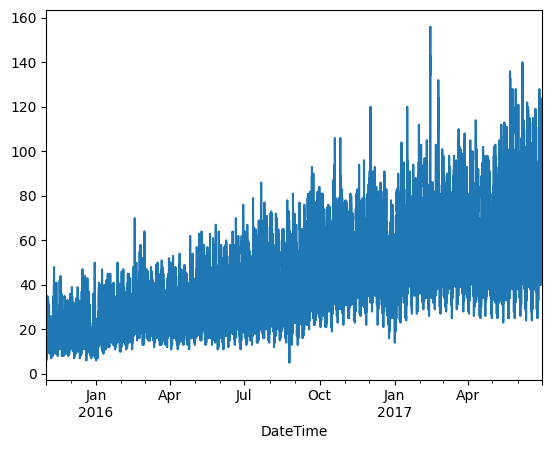

In [ ]:
junc1['Vehicles'].plot()      #no of user will access that junction

In [ ]:
daily_junc1 = junc1.Vehicles.resample('D').mean()   #time series data resampling into dailyjunction by taking mean of the data

In [ ]:
daily_junc1

DateTime
2015-11-01    13.625000
2015-11-02    22.750000
2015-11-03    22.666667
2015-11-04    20.750000
2015-11-05    19.333333
                ...    
2017-06-26    73.916667
2017-06-27    91.125000
2017-06-28    86.666667
2017-06-29    86.916667
2017-06-30    78.458333
Freq: D, Name: Vehicles, Length: 608, dtype: float64

In [ ]:
daily_junc1.shape

(608,)

<Axes: xlabel='DateTime'>

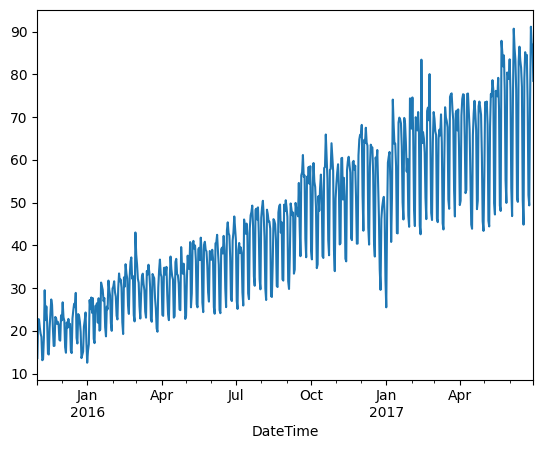

In [ ]:
daily_junc1.plot()

<Axes: >

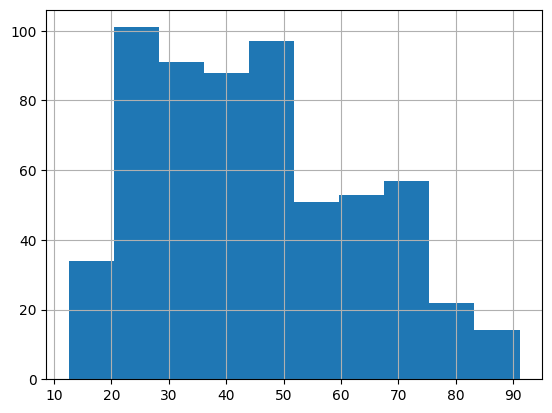

In [ ]:
daily_junc1.hist()      #matplotlib speed observation(freq/speed)

In [ ]:
# Defining a function that creates sequences and targets
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):     #generate no of sequences based on start and stop val
        # Get current sequence
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [ ]:
class SequenceDataset(Dataset):       #here wr organize and prepare data for use in pytorch
#The constructor method initializes the dataset. It takes a pandas DataFrame df as input, which presumably contains sequences and their associated targets.
#These sequences and targets are expected to be stored in the 'sequence' and 'target' columns of the DataFrame.
    def __init__(self, df):
        self.data = df
#This method is called when you want to retrieve an item from the dataset. It takes an index idx as input and returns a single sample from the dataset.
#The sample is a tuple of two torch Tensors: one for the sequence and the other for the target.
    def __getitem__(self, idx):
        sample = self.data[idx]
        #data sample is converted to torch Tensors before being returned. This is done to ensure that the data is in the appropriate format for training PyTorch models.
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

In [ ]:
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window

In [ ]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [ ]:
len(sequences) # sanity check, should be len(data) - lookback = 608 - 7

601

In [ ]:
dataset = SequenceDataset(sequences)

In [ ]:
split = 0.67 # Train/Test Split ratio

In [ ]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]

In [ ]:
lens          #return no of item in an obj

[402, 199]

In [ ]:
# random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

In [ ]:
# sequential split of dataset into train and test set
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

In [ ]:
BATCH_SIZE = 8 # Training batch size

In [ ]:
# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# reshape the data to be used as an input for LSTM
daily_junc1_ts = daily_junc1.values.astype('float32')
daily_junc1_ts = np.reshape(daily_junc1_ts, (len(daily_junc1_ts),-1))

In [ ]:
# define a simple LSTM model
class SimpleLSTM(nn.Module):      #to train & build layers of neural network
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size #output size
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, output_size) #fully connected last layer

        self.relu = nn.ReLU() #return output based on input

    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #cell state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        #output = output[:,-1,:] # when using the last element of the output
        #hn = hn.view(-1, self.hidden_size) # when using the hidden state for forecasting
        out = self.relu(output)
        #out = self.relu(hn) # when using the hidden state for forecasting
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 1 #output size

In [ ]:
r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class

In [ ]:
num_epochs = 100        #how many times data passed through neural network
learning_rate = 0.01    #how many times models weights updated

In [ ]:
# define an optimizer, loss function, and data loader
r_optimizer = optim.Adam(r_model.parameters())
loss_fn = nn.MSELoss()

In [ ]:
summary(r_model, input_size=(1, 7, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 7, 1]                 --
├─LSTM: 1-1                              [1, 7, 64]                17,152
├─ReLU: 1-2                              [1, 7, 64]                --
├─Linear: 1-3                            [1, 7, 32]                2,080
├─ReLU: 1-4                              [1, 7, 32]                --
├─Linear: 1-5                            [1, 7, 1]                 33
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

In [ ]:
t_losses = []         #fun return difference b/w model predicted and actual output

for epoch in range(num_epochs):

    train_loss = 0.0

    r_model.train()

    for X_batch, y_batch in r_trainloader:
        r_optimizer.zero_grad()

        y_pred = r_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()

        loss.backward()
        r_optimizer.step()
    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue

    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))     #point where time starts  to find trainning accuracy and loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train MSE 2286.0026
Epoch 10: train MSE 64.7916
Epoch 20: train MSE 28.9127
Epoch 30: train MSE 26.0307
Epoch 40: train MSE 24.9282
Epoch 50: train MSE 23.6555
Epoch 60: train MSE 23.7668
Epoch 70: train MSE 25.9472
Epoch 80: train MSE 23.3299
Epoch 90: train MSE 22.9715


In [ ]:
s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
#This line creates an instance of the Adam optimizer, which is a popular optimization algorithm used for training neural networks. You pass r_model.parameters() as an argument to the optimizer. This indicates that the optimizer will update the parameters (weights and biases) of the r_model during training.
#The Adam optimizer is known for its ability to adapt the learning rates for each parameter individually and is commonly used in deep learning tasks.
#This line defines the loss function to be used during training. In this case, you are using Mean Squared Error (MSE) loss. MSE loss is a common choice for regression tasks, and it measures the average squared difference between the model's predictions and the actual target values.
#It's often used for tasks like time series forecasting when you want to minimize the difference between the predicted values and the true values.
s_optimizer = optim.Adam(s_model.parameters())        #gradient decent algorithm
loss_fn = nn.MSELoss()

In [ ]:
t_losses = []

for epoch in range(num_epochs):

    train_loss = 0.0

    s_model.train()

    for X_batch, y_batch in s_trainloader:
        s_optimizer.zero_grad()
        y_pred = s_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()

        loss.backward()
        s_optimizer.step()
    epoch_loss = train_loss / len(s_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue

    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

Epoch 0: train MSE 1438.0674
Epoch 10: train MSE 55.4582
Epoch 20: train MSE 22.7526
Epoch 30: train MSE 20.5000
Epoch 40: train MSE 19.0276
Epoch 50: train MSE 16.8539
Epoch 60: train MSE 16.7353
Epoch 70: train MSE 16.7173
Epoch 80: train MSE 16.2887
Epoch 90: train MSE 15.9379


In [ ]:
unshuffled_dataloader= DataLoader(dataset,shuffle=False)
#you are creating a new data loader named unshuffled_dataloader by using the DataLoader class on your dataset object.
#The key difference is that you've set the shuffle parameter to False.

In [ ]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            p = p[:,-1,:]
            predictions.append(p)
            actuals.append(y)
            #actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()

    #This function is designed to be used after training your model to make predictions on a test dataset using your unshuffled data loader.
    #It will provide you with the model's predictions and the corresponding actual target values for evaluation.

In [ ]:
r_preds, actuals = make_predictions_from_dataloader(r_model, unshuffled_dataloader)

#You can use these predictions and actual values to evaluate the performance of your model, compare them,
#and calculate various evaluation metrics (e.g., mean squared error, root mean squared error, etc.) to assess how well your LSTM model is performing on the test data.
#redicted values are stored in the r_preds variable, and the actual target values are stored in the actuals variable.
#Both r_preds and actuals are returned from the function. r_preds contains the model's predictions, and actuals contains the actual target values from your test dataset.

In [ ]:
s_preds, actuals = make_predictions_from_dataloader(s_model, unshuffled_dataloader)

In [ ]:
def one_step_forecast(model, history):
    '''
    model: PyTorch model object
    history: a sequence of values representing the latest values of the time
    series, requirement -> len(history.shape) == 2

    outputs a single value which is the prediction of the next value in the
    sequence.
    '''
    model.eval()
    with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = model(pre)
        pred = pred[:,-1,:]
    return pred.detach().numpy().reshape(-1)

In [ ]:
forecast = one_step_forecast(r_model, daily_junc1_ts)
forecast

array([37.335987], dtype=float32)

In [ ]:
def n_step_forecast(data, model, lookback: int, n: int, forecast_from: int=None):
    '''
    n: integer defining how many steps to forecast
    forecast_from: integer defining which index to forecast from. None if
    you want to forecast from the end.
    plot: True if you want to output a plot of the forecast, False if not.
    '''
    history = data.copy()

    # Create initial sequence input based on where in the series to forecast
    # from.
    if forecast_from:
        pre = list(history[forecast_from - lookback : forecast_from])
    else:
        pre = list(history)[-lookback:]

    # Call one_step_forecast n times and append prediction to history
    for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-lookback:]).reshape(-1, 1)
        forecast = one_step_forecast(model, pre_)
        #forecast = forecast[:,-1,:]
        pre.append(forecast)

    # The rest of this is just to add the forecast to the correct time of
    # the history series
    res = history.copy()
    ls = [np.nan for i in range(len(history))]

    # Note: I have not handled the edge case where the start index + n is
    # before the end of the dataset and crosses past it.
    if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
    else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
        forecast = res.forecast[-n:]
        forecast.index = pd.date_range('2017-07-01', periods=n, freq='D')

    #return res
    return forecast

In [ ]:
r_lstm_forecast = n_step_forecast(daily_junc1_ts, r_model, lookback=7, n=30)
r_lstm_forecast

2017-07-01    [52.294098]
2017-07-02    [50.448048]
2017-07-03     [77.32618]
2017-07-04    [84.368645]
2017-07-05     [84.23206]
2017-07-06    [83.746346]
2017-07-07    [78.382576]
2017-07-08    [52.738743]
2017-07-09     [50.96129]
2017-07-10    [78.124565]
2017-07-11    [82.927956]
2017-07-12     [83.01894]
2017-07-13    [82.604774]
2017-07-14     [78.03404]
2017-07-15    [53.173904]
2017-07-16    [51.301334]
2017-07-17    [78.115074]
2017-07-18    [82.346886]
2017-07-19    [82.431854]
2017-07-20     [82.07707]
2017-07-21     [77.72391]
2017-07-22    [53.553318]
2017-07-23    [51.484875]
2017-07-24     [77.93729]
2017-07-25     [82.02803]
2017-07-26     [82.11912]
2017-07-27     [81.79083]
2017-07-28     [77.50075]
2017-07-29    [53.861958]
2017-07-30     [51.57523]
Freq: D, Name: forecast, dtype: object

In [ ]:
s_lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
s_lstm_forecast

2017-07-01     [50.66218]
2017-07-02     [49.68189]
2017-07-03     [65.89428]
2017-07-04    [67.788864]
2017-07-05    [66.977905]
2017-07-06     [65.87362]
2017-07-07     [63.49531]
2017-07-08    [50.248314]
2017-07-09     [49.69722]
2017-07-10    [61.299076]
2017-07-11     [62.85453]
2017-07-12    [62.428726]
2017-07-13    [61.881725]
2017-07-14    [60.622517]
2017-07-15    [51.470062]
2017-07-16    [50.566753]
2017-07-17     [59.81967]
2017-07-18    [61.292446]
2017-07-19     [61.04779]
2017-07-20    [60.727894]
2017-07-21    [59.866657]
2017-07-22    [54.833725]
2017-07-23    [53.439358]
2017-07-24     [59.59225]
2017-07-25    [60.770203]
2017-07-26    [60.637604]
2017-07-27    [60.431637]
2017-07-28     [59.85382]
2017-07-29    [57.712093]
2017-07-30    [57.054493]
Freq: D, Name: forecast, dtype: object

In [ ]:
# helper function to prepare modeled results
def prepare_results(model, preds, data, lookback):

    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=daily_junc1.index)
    return sample_df

In [ ]:
r_modeled = prepare_results(r_model, r_preds, daily_junc1_ts, lookback=7)
r_modeled

,0
DateTime,
2015-11-01,NaN
2015-11-02,NaN
2015-11-03,NaN
2015-11-04,NaN
2015-11-05,NaN
...,...
2017-06-26,78.416061
2017-06-27,81.346413
2017-06-28,83.974800


In [ ]:
s_modeled = prepare_results(s_model, s_preds, daily_junc1_ts, lookback=7)
s_modeled

,0
DateTime,
2015-11-01,NaN
2015-11-02,NaN
2015-11-03,NaN
2015-11-04,NaN
2015-11-05,NaN
...,...
2017-06-26,65.670448
2017-06-27,67.334381
2017-06-28,66.678787


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# helper function to plot all the results for comparison
def plot_results(original, modeled, forecast):
    """ Given
        original: a time series with datetime index
        modeled: model fitted values
        forecast: inferenced values

        Plot the original time series and the prediction of the test set
    """

    # calculate RMSE values between the original and modeled
    error = root_mean_squared_error(original[train_len+lookback+1:],modeled[train_len+lookback+1:])

    # plot
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='y', label="forecast")
    plt.axvspan(original.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True);

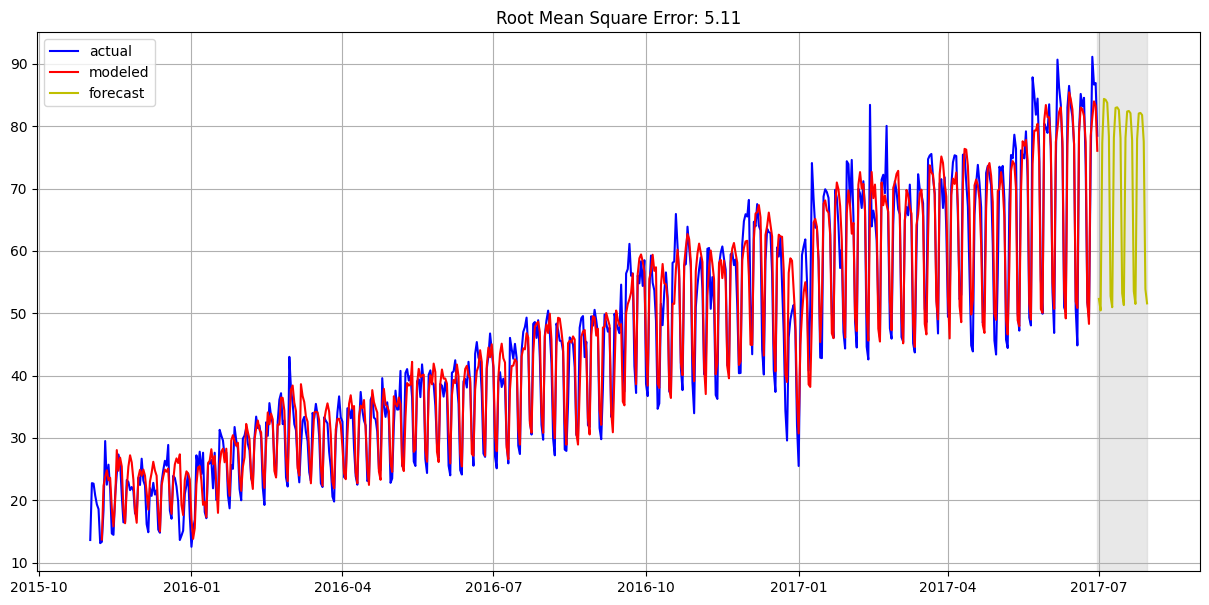

In [ ]:
plot_results(daily_junc1, r_modeled, r_lstm_forecast)

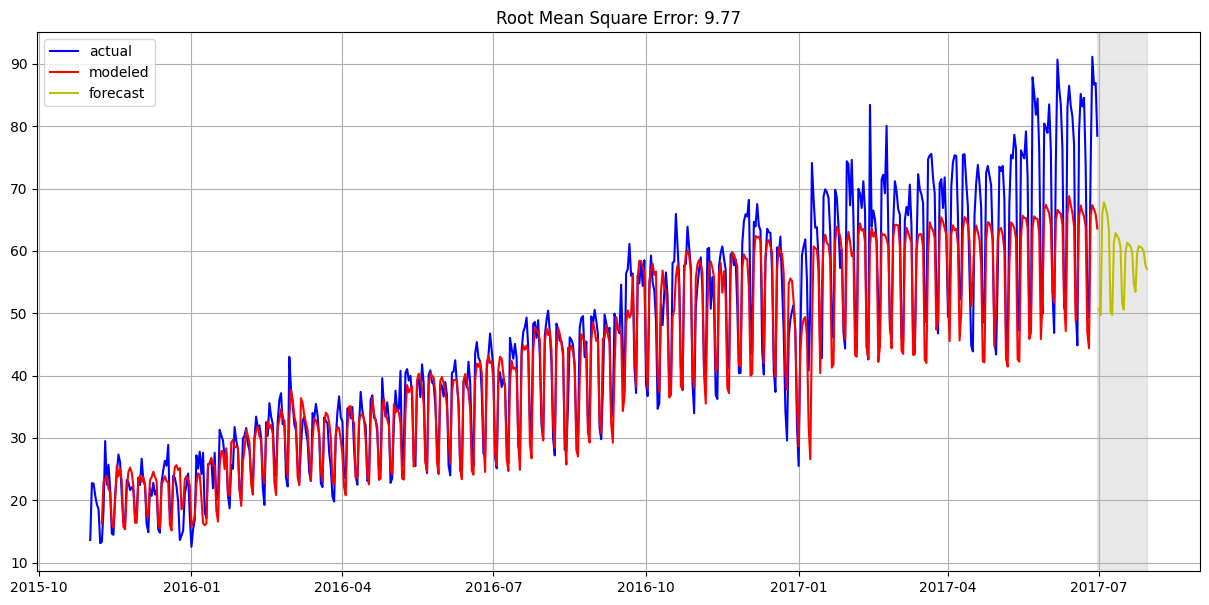

In [ ]:
plot_results(daily_junc1, s_modeled, s_lstm_forecast)